# Tracking with btrack

Duration : 120 images with confluent cells in the end and pretty crowded in the beginning -> 352 s.

In [1]:
import cv2
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy
from skimage import measure # to get contours from masks

# btrack module and configuration file
import btrack
from btrack.dataio import localizations_to_objects
from btrack.constants import BayesianUpdates
from btrack.render import plot_tracks

import imagecodecs
import napari

C:\ProgramData\Anaconda3\lib\site-packages\napari\_qt\__init__.py:37: UserWarning: 
    napari was tested with QT library `>=5.12.3`.
    The version installed is 5.9.7. Please report any issues with this
    specific QT version at https://github.com/Napari/napari/issues.
    
  warn(message=warn_message)


## I. Load segmentation results

Attention : les prédictions sont encodées en float32 bits (sortie du réseau de neurones...).

(120, 512, 512) (120, 512, 512)


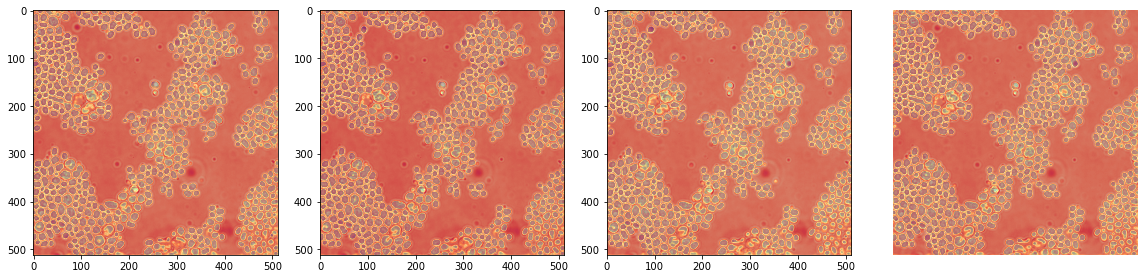

In [3]:
os.chdir("D:/Hugo/Anaphase/Structured/H449")  # root dir containg Predictions and Images Path
predictions_path = "S0-H449_1_1-120.tif"
corresponding_imgs = "BF_1-120.tif"

predictions = imageio.volread(predictions_path)
imgs = imageio.volread(corresponding_imgs)

print(predictions.shape, imgs.shape)

# plot images and masks
nb_imgs = 4
fig, ax = plt.subplots(1, nb_imgs, figsize=(16, 10))
for i, im in enumerate(imgs[:nb_imgs]):
    ax[i].imshow(imgs[i], cmap="Spectral")
    ax[i].imshow(predictions[i], cmap="Spectral", alpha=0.4)
    plt.axis("off")

plt.tight_layout()

# Cast to 8-bit depth images prior to thresholding
u8_predictions = []
for p in predictions:
    u8_p = p - p.min()
    u8_p = u8_p / u8_p.max() * 255
    u8_predictions.append(np.uint8(u8_p))
u8_predictions = np.array(u8_predictions)

## II. Get contours

### Thresholding to get the masks

uint8


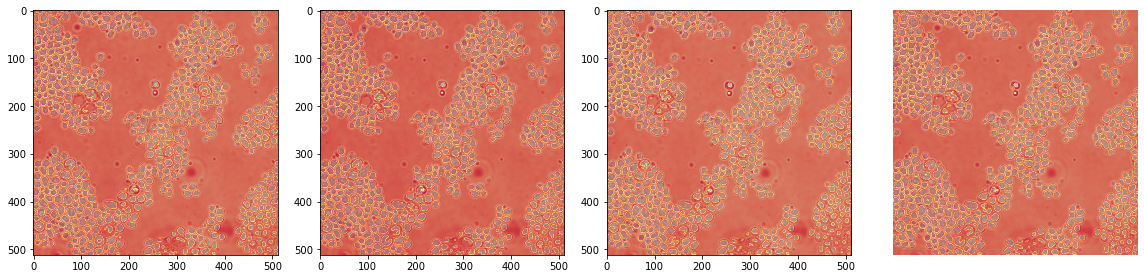

In [4]:
threshold = 200
_, masks = cv2.threshold(u8_predictions, threshold, 255, cv2.THRESH_BINARY) # threshold : seuil / masks : images seuillees

print(masks.dtype) # masks are 8-bit

# plot images and masks
nb_imgs = 4
fig, ax = plt.subplots(1, nb_imgs, figsize=(16, 10))
for i, im in enumerate(imgs[:nb_imgs]):
    ax[i].imshow(imgs[i], cmap="Spectral")
    ax[i].imshow(masks[i], cmap="Spectral", alpha=0.4)
    plt.axis("off")

plt.tight_layout()

In [4]:
print(masks.shape)

(120, 512, 512)


### Retrieve contours using skimage

<ipython-input-5-4ec268f045e3>:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  all_contours.append(np.array(c)) #threshold is defined when thresholding
<ipython-input-5-4ec268f045e3>:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  all_contours = np.array(all_contours)


(120,)


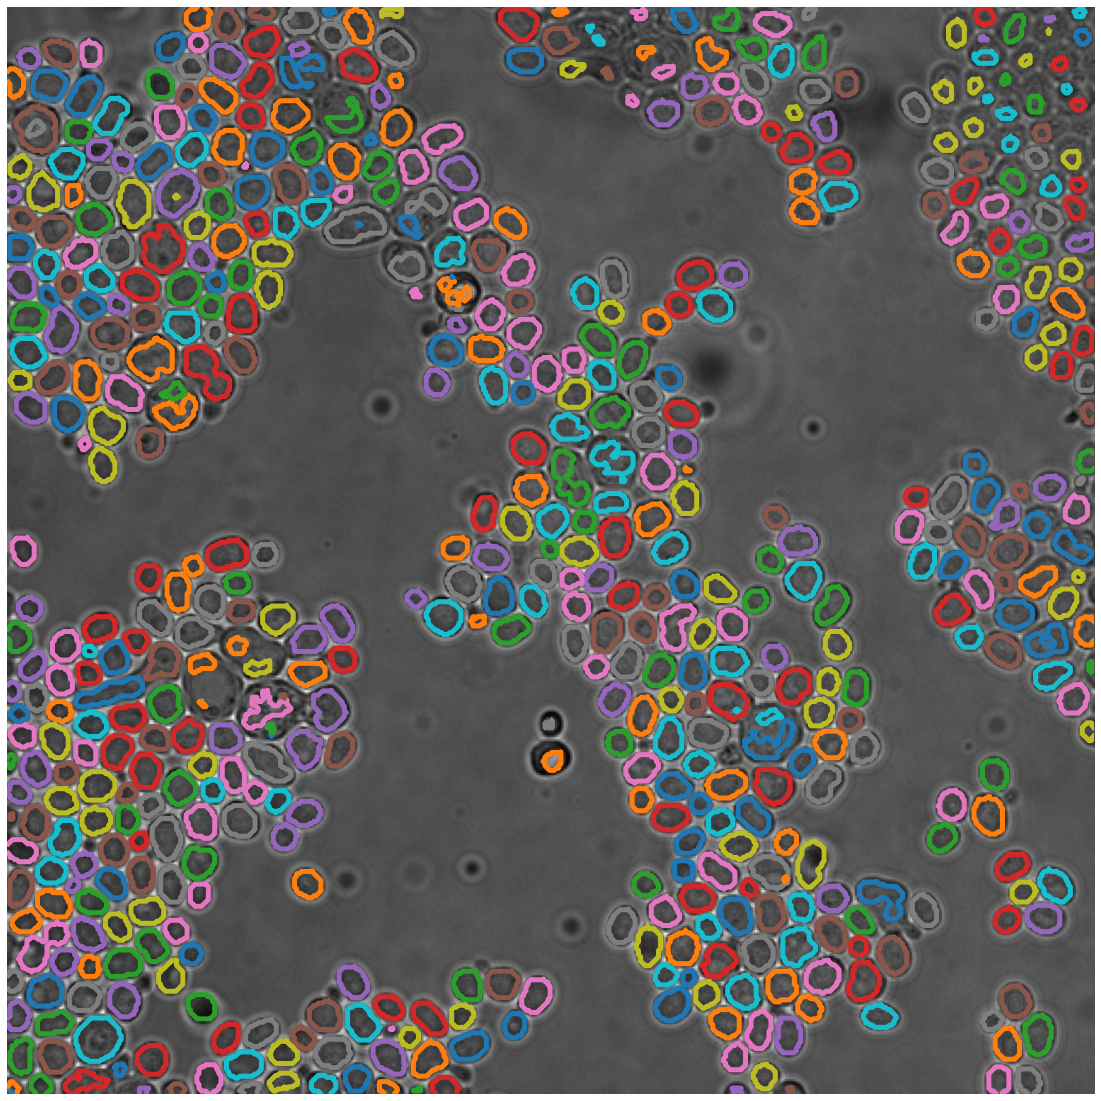

In [5]:
import matplotlib.colors as mcolors
by_hsv = [(tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(color))),
                         name)
                        for name, color in mcolors.TABLEAU_COLORS.items()]
names = [name for hsv, name in by_hsv]
# Way easier to get contours in skimage than with opencv..!
all_contours = []
for m in masks:
    c = measure.find_contours(m, threshold)
    all_contours.append(np.array(c)) #threshold is defined when thresholding
all_contours = np.array(all_contours)

print(all_contours.shape)

# Display the images and plot all contours found
nb_imgs = 1
fig, ax = plt.subplots(1, 1, figsize=(20, 20))

for i, (contour_im, im) in enumerate(zip(all_contours[2:3], imgs[2:3])):
    ax.imshow(cv2.resize(im, (512, 512)), cmap="gray", origin="lower")
    for i, contour in enumerate(contour_im):
        ax.plot(contour[:, 1], contour[:, 0], linewidth=5, c=names[i % len(names)])
    ax.axis("off")

## III. Peform tracking using the surface and position of each cell at each time point

### Get the barycenter (position) of each cell at each time point and store them in a DataFrame

(117116, 4)


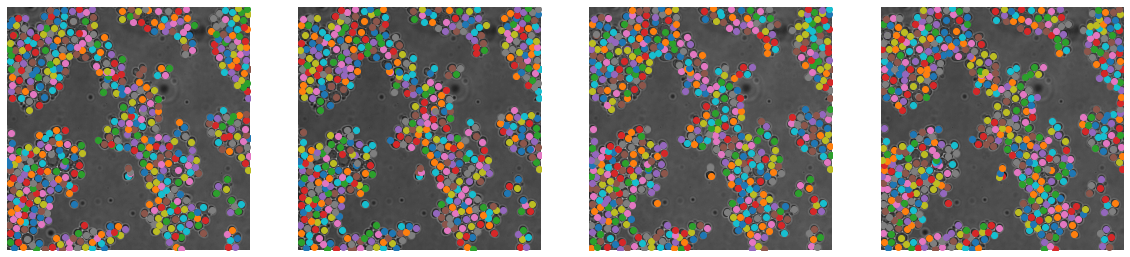

In [6]:
# retrieve all barycenters and shape a datastructure for btrack
positions_at_frames = []
for i, frame in enumerate(all_contours):
    for cell in frame:
        positions_at_frames.append({"t": i, "x": np.sum(cell[:, 1]) / cell.shape[0], "y": np.sum(cell[:, 0]) / cell.shape[0], "Contours": cell})
positions_per_frame = pd.DataFrame(positions_at_frames)

# check the shape
print(positions_per_frame.shape)
positions_per_frame.head()

# Display the image and plot the barycenters to check if they're correct
nb_imgs = 4
fig, ax = plt.subplots(1, nb_imgs, figsize=(20, 20))

for i, (contour_im, im) in enumerate(zip(all_contours[:nb_imgs], imgs[:nb_imgs])):
    ax[i].imshow(cv2.resize(im, (512, 512)), cmap="gray", origin="lower")
    for idx, cell in positions_per_frame[positions_per_frame["t"] == i].iterrows():
        x, y = cell["x"], cell["y"]
        ax[i].scatter(x, y)
    ax[i].axis("off")

### Run position-based tracking with btrack

In [7]:
import time

# os.chdir("D:/Hugo/Python_Scripts/Notebooks")
MODE = BayesianUpdates.APPROXIMATE # APPROXIMATE or EXACT
objects = localizations_to_objects(positions_per_frame)
objects[0]

t0 = time.time()

# initialise a tracker session using a context manager
with btrack.BayesianTracker() as tracker:

  # configure the tracker using a config file (example config file used here)
  tracker.configure_from_file("config_file.json")

  # set the update method and maximum search radius (both optional)
  tracker.update_method = MODE
  tracker.max_search_radius = 200

  # append the objects to be tracked
  tracker.append(objects)

  # set the volume (Z axis volume is set very large for 2D data)
  tracker.volume=((0,600),(0,800),(-1e5,1e5))

  # track them (in interactive mode)
  tracker.track_interactive(step_size=100)

  # generate hypotheses and run the global optimiser
  tracker.optimize()

  # get the tracks as a python list
  tracks = tracker.tracks
  box = tracker.volume
    
tf = time.time()
print(f"Tracking duration : {round(tf - t0, 2)} seconds.")

[INFO][2021/04/30 03:55:30 PM] Objects are of type: <class 'pandas.core.frame.DataFrame'>
[INFO][2021/04/30 03:55:31 PM] Loaded btrack: C:\ProgramData\Anaconda3\lib\site-packages\btrack\libs\libtracker.DLL
[INFO][2021/04/30 03:55:31 PM] btrack (v0.4.0) library imported
[INFO][2021/04/30 03:55:31 PM] Setting max XYZ search radius to: 100
[INFO][2021/04/30 03:55:31 PM] Starting BayesianTracker session
[INFO][2021/04/30 03:55:31 PM] Loading configuration file: config_file.json
[INFO][2021/04/30 03:55:31 PM] Loading motion model: b'cell_motion'
[INFO][2021/04/30 03:55:31 PM] Setting Bayesian update method to: BayesianUpdates.APPROXIMATE
[INFO][2021/04/30 03:55:31 PM] Setting max XYZ search radius to: 200
[INFO][2021/04/30 03:55:31 PM] Objects are of type: <class 'list'>
[INFO][2021/04/30 03:55:31 PM] Set volume to ((0, 600), (0, 800), (-100000.0, 100000.0))
[INFO][2021/04/30 03:55:31 PM] Starting tracking... 
[INFO][2021/04/30 03:55:31 PM] Tracking objects in frames 0 to 99 (of 120)...
[IN

Tracking duration : 363.04 seconds.


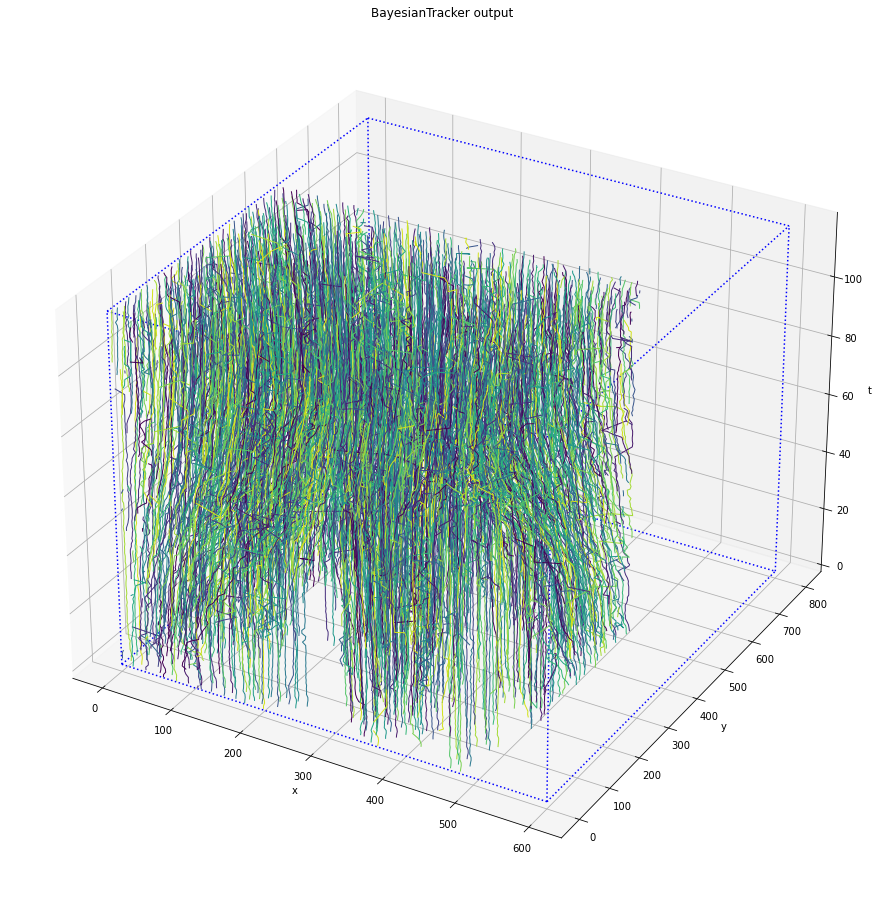

In [9]:
# plot the tracks in 3D
plot_tracks(tracks, order='xyt', box=box)

### Interactive view of the tracking results with napari

In [10]:
# Convert from the btrack format (data structure == OrderedDict) into a format that is accepted by Napari (i.e. numpy array)
tracks_to_napari = []
for track in tracks:
    for i, frame in enumerate(track.t):
        tracks_to_napari.append({"ID": track.ID, "Frame": frame, "X": track.y[i], "Y": track.x[i]})
tracks_to_napari = pd.DataFrame(tracks_to_napari)

print(tracks_to_napari.shape)
print(tracks_to_napari[:10])

(119299, 4)
    ID  Frame          X           Y
0  398      0  30.472674  237.957447
1  398      1  31.004402  238.061224
2  398      2  31.693682  238.577778
3  398      3  31.604793  238.577778
4  398      4  31.560349  236.622222
5  398      5  32.110972  236.595745
6  398      6  31.582571  236.555556
7  398      7  32.147259  237.020408
8  398      8  30.538126  237.488889
9  398      9  30.045218  238.836735


In [13]:
resized = []
for im in imgs:
    resized.append(cv2.resize(im, (512, 512)))
resized = np.array(resized)

with napari.gui_qt():
    viewer = napari.view_image(resized)
    viewer.add_image(u8_predictions, opacity=0.5, colormap="blue", blending="additive")
    viewer.add_tracks(tracks_to_napari)

### Retrive the contours of each cell over time 
Here one line corresponds to one cell, at one frame. We want to add the contours of that cell (previously computed from the masks) at the same line.

In [12]:
# retrieve contours from tracks
tracks_and_contours, contours = [], []
for idx, track in tracks_to_napari.iterrows():
    
    if idx % 1000 == 0: # monitoring progress
        print(f"Number of analyzed lines: {idx}")
        
    # retrieve the contours corresponding to this track at this frame (one cell only)
    mask = ((positions_per_frame["t"] == track["Frame"]) & (track["X"] == positions_per_frame["y"]) & (track["Y"] == positions_per_frame["x"]))
    corresponding_contours = positions_per_frame[mask]["Contours"]
    tracks_and_contours.append({"ID": track["ID"], "Frame": track["Frame"], "X": track["X"], "Y": track["Y"], "Contours": corresponding_contours})
    try:
        contours.append(corresponding_contours.to_numpy()[0])
    except:
        contours.append([])

tracks_and_contours = pd.DataFrame(tracks_and_contours)
contours = np.array(contours)

print(tracks_and_contours.shape, contours.shape)
tracks_and_contours.head()

Number of analyzed lines: 0
Number of analyzed lines: 1000
Number of analyzed lines: 2000
Number of analyzed lines: 3000
Number of analyzed lines: 4000
Number of analyzed lines: 5000
Number of analyzed lines: 6000
Number of analyzed lines: 7000
Number of analyzed lines: 8000
Number of analyzed lines: 9000
Number of analyzed lines: 10000
Number of analyzed lines: 11000
Number of analyzed lines: 12000
Number of analyzed lines: 13000
Number of analyzed lines: 14000
Number of analyzed lines: 15000
Number of analyzed lines: 16000
Number of analyzed lines: 17000
Number of analyzed lines: 18000
Number of analyzed lines: 19000
Number of analyzed lines: 20000
Number of analyzed lines: 21000
Number of analyzed lines: 22000
Number of analyzed lines: 23000
Number of analyzed lines: 24000
Number of analyzed lines: 25000
Number of analyzed lines: 26000
Number of analyzed lines: 27000
Number of analyzed lines: 28000
Number of analyzed lines: 29000
Number of analyzed lines: 30000
Number of analyzed li

<ipython-input-12-c8bb0b8cf659>:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  contours = np.array(contours)


ID  Frame          X           Y  \
0  398.0    0.0  30.472674  237.957447   
1  398.0    1.0  31.004402  238.061224   
2  398.0    2.0  31.693682  238.577778   
3  398.0    3.0  31.604793  238.577778   
4  398.0    4.0  31.560349  236.622222   

                                            Contours  
0  38    [[36.21568627450981, 239.0], [36.2156862...  
1  626    [[37.21568627450981, 239.0], [37.215686...  
2  1212    [[37.21568627450981, 241.0], [37.21568...  
3  1803    [[37.21568627450981, 241.0], [37.21568...  
4  2405    [[37.21568627450981, 239.0], [37.21568...

Text(0.5, 0.98, 'Bright-field images, with the barycenter and the contours of each cell')

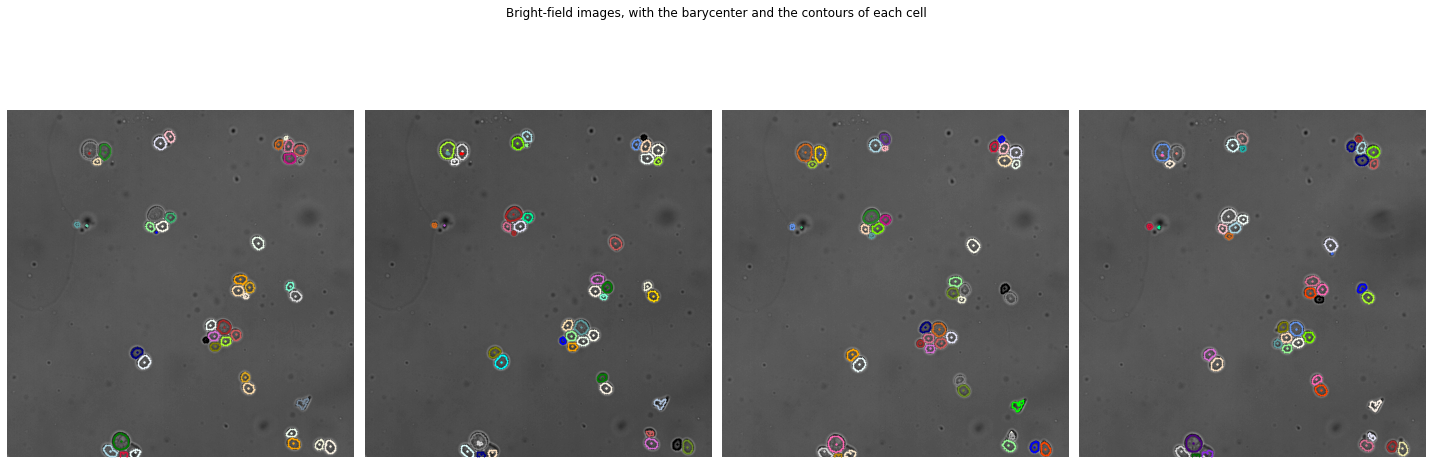

In [13]:
# get matplotlib colors
import matplotlib.colors as mcolors
by_hsv = [(tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(color))),
                         name)
                        for name, color in mcolors.CSS4_COLORS.items()]
names = [name for hsv, name in by_hsv]

# Display the image and plot the barycenters to check if they're correct
nb_imgs = 4
fig, ax = plt.subplots(1, nb_imgs, figsize=(20, 6))
for i, im in enumerate(imgs[:nb_imgs]):
    ax[i].imshow(cv2.resize(im, (512, 512)), cmap="gray", origin="lower")
    at_this_frame = tracks_and_contours[tracks_and_contours["Frame"] == i]
    for idx, cell in at_this_frame.iterrows():
        x, y = cell["Y"], cell["X"]
        ax[i].scatter(x, y, c=names[(i + idx) % len(names)], s=2)
        contour = cell["Contours"].items()
        for _, cont in contour:
            for point in cont:
                ax[i].plot(point[1], point[0], ".", c=names[(i + idx) % len(names)], markersize=1)
    ax[i].axis("off")

fig.tight_layout()
fig.suptitle("Bright-field images, with the barycenter and the contours of each cell")

### Save the Tracking results (DataFrame) and the contours (npy) to files

In [18]:
save_path = "Data/Tracking_Results_BF_f0001-1-100.1.csv"
tracks_and_contours.drop("Contours", axis=1).to_csv(save_path, sep=",")

In [15]:
# save contours in a separate file
save_path = "Data/Contours_BF_f0001-1-100.npy"
np.save(save_path, contours)

In [16]:
ar = np.load(save_path, allow_pickle=True)
print(ar.shape)

(22423,)
